Research on Moscow flats prices. Link for the dataset in Kaggle: https://www.kaggle.com/datasets/hugoncosta/price-of-flats-in-moscow 

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
import warnings
warnings.filterwarnings('ignore')

In [2]:
# download the data and glimpse on it
df = pd.read_csv(r"C:\Users\shuva\Downloads\df\df\flats_moscow.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2040 non-null   int64  
 1   price       2040 non-null   int64  
 2   totsp       2040 non-null   int64  
 3   livesp      2040 non-null   int64  
 4   kitsp       2040 non-null   float64
 5   dist        2040 non-null   float64
 6   metrdist    2040 non-null   int64  
 7   walk        2040 non-null   int64  
 8   brick       2040 non-null   int64  
 9   floor       2040 non-null   int64  
 10  code        2040 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 175.4 KB


Variables description: price - flat price in $ 1000, totsp - total flat area in sq meters, livesp - living area in sq meters, kitsp - kitchen area in sq meters, dist - distance to the city center in km, metrdist - distance to metro station in minutes, walk - binary variable "is it possible to get to the metro on foot?" (1 - yes, 0 - no), brick - binary variable if the house is constructed of brick (1 - yes, 0 - no), floor - binary variable (0 - first or last floor, 1 - other); code - a number from 1 to 8, with which the data is grouped observations by subsamples: 1. Observations are grouped in the north, around the Kaluga-Riga metro; line 2. North, around the Serpukhovsko-Timiryazevskaya metro line; 3. Northwest, around the Zamoskvoretskaya metro line; 4. Northwest, around the Tagansko-Krasnopresnenskaya metro line; 5. Southeast, around the Lublin metro line; 6. Southeast, around Tagansko-Krasnopresnenskaya metro line; 7. East, around Kalininskaya metro line; 8. East, around Arbatsko-Pokrovskaya metro line

In [3]:
# drop unnecessary column
df = df.drop(columns='Unnamed: 0')

In [4]:
# let's look at linear correlations between variables
round(df.corr(),2)

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
price,1.00,0.76,0.73,0.60,-0.33,-0.15,0.15,0.26,0.13,-0.09
totsp,0.76,1.00,0.86,0.78,-0.11,-0.04,0.01,0.12,0.11,-0.02
livesp,0.73,0.86,1.00,0.57,-0.20,-0.05,0.06,0.25,0.09,-0.01
kitsp,0.60,0.78,0.57,1.00,-0.06,-0.03,-0.01,-0.02,0.12,-0.05
dist,-0.33,-0.11,-0.20,-0.06,1.00,0.10,-0.18,-0.39,0.02,-0.19
metrdist,-0.15,-0.04,-0.05,-0.03,0.10,1.00,-0.04,-0.07,-0.02,-0.00
walk,0.15,0.01,0.06,-0.01,-0.18,-0.04,1.00,0.15,-0.02,-0.04
brick,0.26,0.12,0.25,-0.02,-0.39,-0.07,0.15,1.00,-0.05,0.05
floor,0.13,0.11,0.09,0.12,0.02,-0.02,-0.02,-0.05,1.00,-0.05
code,-0.09,-0.02,-0.01,-0.05,-0.19,-0.00,-0.04,0.05,-0.05,1.00


There are strong linear correlations between price and totsp and price and livesp
Let's build scatter plots

In [5]:
# let's look at non-linear correlations between variables
round(df.corr(method='spearman'),2)

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
price,1.00,0.77,0.67,0.65,-0.37,-0.15,0.18,0.27,0.16,-0.09
totsp,0.77,1.00,0.82,0.80,-0.11,-0.01,0.00,0.10,0.12,-0.00
livesp,0.67,0.82,1.00,0.54,-0.20,-0.03,0.05,0.24,0.09,0.01
kitsp,0.65,0.80,0.54,1.00,-0.03,-0.00,-0.03,-0.06,0.12,-0.04
dist,-0.37,-0.11,-0.20,-0.03,1.00,0.11,-0.18,-0.40,0.03,-0.25
metrdist,-0.15,-0.01,-0.03,-0.00,0.11,1.00,-0.05,-0.07,-0.03,0.00
walk,0.18,0.00,0.05,-0.03,-0.18,-0.05,1.00,0.15,-0.02,-0.04
brick,0.27,0.10,0.24,-0.06,-0.40,-0.07,0.15,1.00,-0.05,0.05
floor,0.16,0.12,0.09,0.12,0.03,-0.03,-0.02,-0.05,1.00,-0.05
code,-0.09,-0.00,0.01,-0.04,-0.25,0.00,-0.04,0.05,-0.05,1.00


Spearman rank correlations between price and totsp and kitsp is higher than linear ones, so it can indicate the presence of non-linear causation

In [6]:
# dummy variables for code
df = pd.get_dummies(df, columns=['code'], drop_first=1, dtype=int)

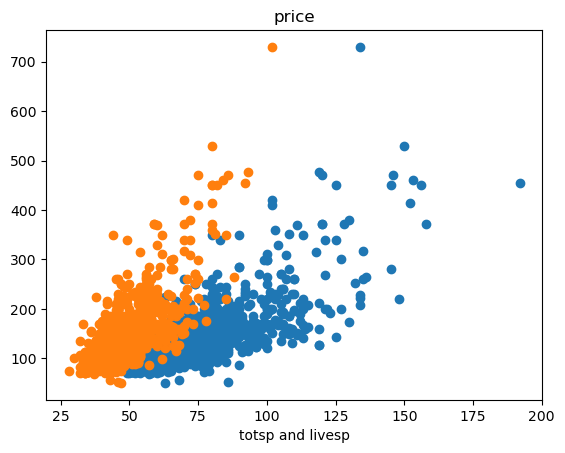

In [7]:
# scatter plot, totsp - blue, livesp - orange
plt.scatter(x=df.totsp, y=df.price)
plt.scatter(x=df.livesp, y=df.price)
plt.title("price")
plt.xlabel("totsp and livesp")
plt.show()

We better use natural log of price, and that of totsp and of livesp

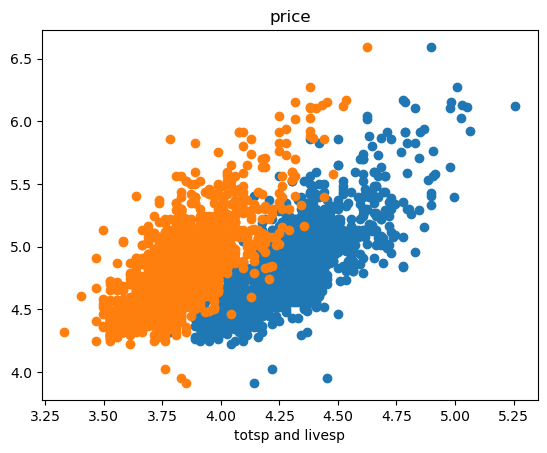

In [8]:
# scatter plot, totsp - blue, livesp - orange
# it looks much better than previous one
plt.scatter(x=np.log(df.totsp), y=np.log(df.price))
plt.scatter(x=np.log(df.livesp), y=np.log(df.price))
plt.title("price")
plt.xlabel("totsp and livesp")
plt.show()

I will use log(price) in upcoming modeling

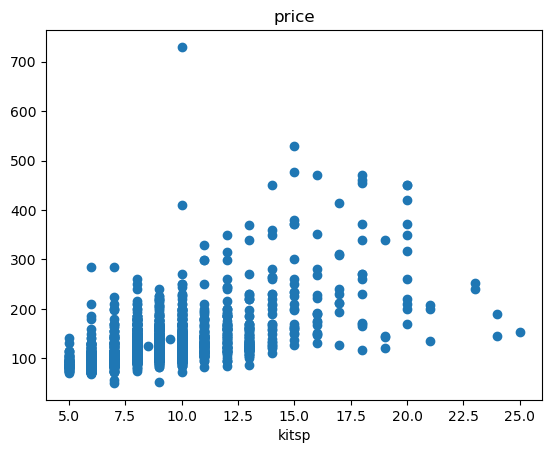

In [9]:
# scatter plot between price and kitsp
plt.scatter(x=df.kitsp, y=df.price)
plt.title("price")
plt.xlabel("kitsp")
plt.show()

Chances are that kitsp is not very informative variable comparing with totsp and livesp, we may observe clasters of flats with similar kitchen area, but different prices. So, the variable may be used as auxiliary variable. All the other variables will be used for the same function.

In [10]:
# divide data into test and train sample
X = df.drop(['price'], axis=1)
y = df['price']
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [11]:
# drop some columns, since they are insignificant in forthcoming regression model
X_train = X_train.drop(columns=['code_4']) 
# regression model
m1 = OLS(y_train,X_train).fit()
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     336.8
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:14:23   Log-Likelihood:                -8654.3
No. Observations:                1836   AIC:                         1.734e+04
Df Residuals:                    1821   BIC:                         1.742e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.6057      5.352     -3.476      0.0

All the coefficients are significant on 5%-level. R-square is significant on 5%-level and is higher than 0.5, so the model has a statistical quality. Durbin-Watson statistic shows the absence of autocorrelation in residuals, but, speaking of autocorrelation in residuals in spatial data (data without time series), computing autocorrelation test makes no sence, since we may resample our data, randomly change the position of observations, and autocorrelation may disappear or vice versa. Let's check the model for heteroscedastisity, since on the scatterplots we observe different conditional variance in data (with the growth of the dependent variables). The insignificance of code_4 means that there is no difference between flats in code 4 area and code 1.

<Axes: ylabel='price'>

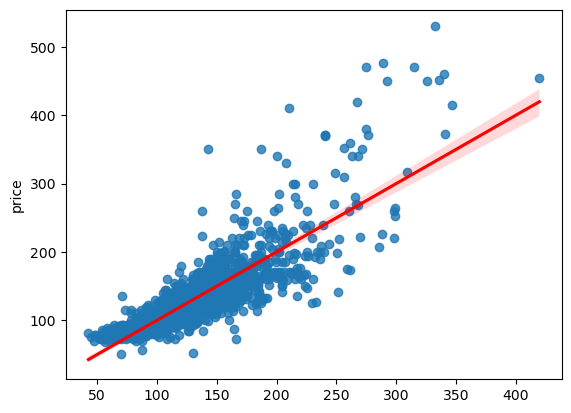

In [12]:
sns.regplot(x=m1.fittedvalues, y=y_train, line_kws={"color": "red"})

As I sad before, variance increases with the growth of the dependent variables, let's compute Breush-Pagan test for heteroscedastisity. We can also see the exponencial charachter of the data, so it makes sence to use logarithms of dependent varible.

In [13]:
# test for heteroscedastisity
print('BP-test statistic and p-value',sms.het_breuschpagan(resid=m1.resid, exog_het=X_train)[:2])

BP-test statistic and p-value (368.5853081349213, 5.160912279878945e-70)


Since BP_test p-value << 0.05, there is a heteroscedastisity, let's try to upgrade the model and to smooth out heteroscedasticity. Let's use the natural logarithms of variables.

In [14]:
# add logs of totsp and livesp
df['log(totsp)'] = np.log(df.totsp)
df['log(livesp)'] = np.log(df.livesp)
df['log(price)'] = np.log(df.price)
df = df.drop(columns=['livesp', 'totsp', 'price', 'code_4', 'log(livesp)', 'code_8']) # drop some columns, since they are insignificant in forthcoming regression model

In [15]:
# divide data into test and train sample
X = df.drop(['log(price)'], axis=1)
y = df['log(price)']
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [16]:
# regression model
m2 = OLS(y_train,X_train).fit()
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:             log(price)   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     549.2
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:14:23   Log-Likelihood:                 915.30
No. Observations:                1836   AIC:                            -1805.
Df Residuals:                    1823   BIC:                            -1733.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4444      0.117      3.808      0.0

All the coefs remain significant on 5%-level, and the R-square increased by ~0.06 from the preious figure.  
Let's compute BP-test again.
The insignificance of code_8 means that there is no difference between flats in code 8 area and that of code 1 and code 4. The insignificance of log(livesp) probably indicates that this variable is highly dependent on total area of the flat, so it definitely makes sense to use log(totsp) only.

In [17]:
# test for heteroscedastisity
print('BP-test statistic and p-value',sms.het_breuschpagan(resid=m2.resid, exog_het=X_train)[:2])

BP-test statistic and p-value (153.42899998383388, 1.14125453924835e-26)


P-value of test remains << 0.05, but test statistic decreased, so we have slightly smoothed out the heteroscedastisity. We will use robust standard errors afterwords, now let's check our model on test data.

<Axes: ylabel='log(price)'>

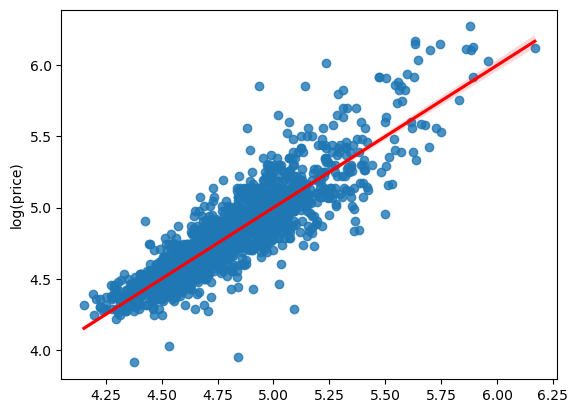

In [18]:
sns.regplot(x=m2.fittedvalues, y=y_train, line_kws={"color": "red"})

New results look much better on the scatterplot, than the predious ones. The data looks more linear and conditional variable is lower.

In [19]:
# let's make a prediction on the test sample
predictions = m2.get_prediction(X_test)
p = predictions.summary_frame(alpha=0.05)
p = p.drop(columns = ['mean_se'])
p['true_value'] = y_test
p['isinci'] = np.where((p['true_value']<=p['obs_ci_upper'])&(p['true_value']>=p['obs_ci_lower']), 1,0)
print('Share of true log(price) values from test sample inside the prediction confidence interval: ',p.isinci.mean())

Share of true log(price) values from test sample inside the prediction confidence interval:  0.946078431372549


Most of true log(price) values are inside the prediction interval. so the model statisticaly adequate

In [20]:
mape(np.exp(y_test), np.exp(p['mean']))

0.10323239714353985

The mape of prediction is slightly above the 10%, so the model is quite accurate (since the mape is lower than 12-15%) and can be used in further predictions. Let's estimate the final model in the whole dataset.

In [21]:
# final 
model = OLS(y,X).fit()
print(model.get_robustcov_results(cov_type='HC3').summary())

                            OLS Regression Results                            
Dep. Variable:             log(price)   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     333.1
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:14:24   Log-Likelihood:                 1012.8
No. Observations:                2040   AIC:                            -2000.
Df Residuals:                    2027   BIC:                            -1927.
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3515      0.161      2.186      0.0

The final model looks like:
log(price) = 0.3515 + 1.0657 log(totsp) + 0.0135 * kitsp - 0.0205 * dist - 0.0088 * metrdist + 0.0899 * walk + 0.0282 * brick + 0.0533 floor - 0.0359 * code_2 + 0.0436 * code_4 - 0.1627 * code_5 - 0.123 * code_6 - 0.09 * code_7, R-sq = 0.782.
It's of good quality since R-sq is significant on 5%-level, so as coefs are. We used robust standard errors to glide the effects of heteroscedastisity. 
Let's try to interprete the results from economic point of view, to make this possible let's tranform coefs through exponent to go to the usual units of measurement ($ 1000).

In [22]:
np.exp(model.params)

const         1.421201
kitsp         1.013565
dist          0.979710
metrdist      0.991200
walk          1.094046
brick         1.028570
floor         1.054706
code_2        0.964718
code_3        1.044542
code_5        0.849845
code_6        0.884281
code_7        0.913888
log(totsp)    2.902756
dtype: float64

The model, after implementation of exponent, looks like this:
y = 1.42 * 2.9^log(totsp) * kitsp^1.0135 * 0.98^dist * 1.09^walk * 1.02^brick * 1.055^floor * 0.96^code_2 * 1.045^code_3 * 0.85^code_5 * 0.88^code_6 * 0.91^code_7; 

So, generally speaking, because of extra log in regressors, it's difficult to get the exact effects of totsp, but it's the most important and influental one - each additional unit of log(totsp) raises the price in 2.9 times.
Constant can't be interprete, since there is no flat out there with 0 area;  
An additional square meter of kitchen space raises the price by 1.35%;  
An additional km far from the Moscow center drops the price down by 2.1%;  
An additional minute of walkin from the nearest metro stationa decreses the price by 0.88%;
The presence of the metro in walking distance increases the price by 9.4%;  
If the house was constructed of brick, the price increases by 2.85%;  
If the floor on which the flat is located is not the 1st of the last, the price increses by 5.47%;
The influence of the codes depends on the district (on its popularity/prestige), so the areas of codes 1, 4, 8 are quite similar, but code 3 district is better (since flats in general cost 4.45% more), and the folowing sequence of codes represents the decline of the prestige of the district comparing to preious ones: 2,7,6,5.  

At the end of a day, the model should be shown to a real estate agency, where the quality and adequacy of our model can be properly estimated from the market point of view.  
One of the problem of the model is quite a big number of regressors, even though there are enouth obrserations, but some of the variables may seem unimportant to realtors.